In [1]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


We will use this function to plot the metrics of our training process, to help in choosing the best model

In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

We will use this function to explore the data

In [0]:
def plot_mnist_image(N, imgs, labels):
  print("The image below should show the number %d" % labels[N])
  plt.imshow(imgs[N,], cmap=plt.cm.binary)
  plt.grid(True)

# The problem

We will recognize handwritten digits. For an image containing a number between 0 and 9, we will recognize the number and will produce an int as output

In [4]:
from keras.datasets import mnist

Using TensorFlow backend.


In [5]:
# Run this to download the data prior to the lecture
train_orig_data, test_orig_data = mnist.load_data()

11493376/11490434 [==============================] - 10s 1us/step


In [7]:
#vamos a echarle un ojo a los datos
type(train_orig_data)

tuple

In [0]:
imgs_orig,label_orig=train_orig_data

In [9]:
imgs_orig.shape

(60000, 28, 28)

In [10]:
label_orig.shape
#son las etiquetas: 0->255

(60000,)

The image below should show the number 5


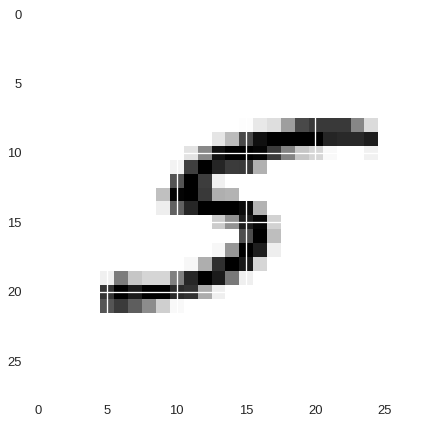

In [13]:
#vemos la imagen que esta la posicion en la 523
plot_mnist_image(523,imgs_orig,label_orig)

The image below should show the number 7


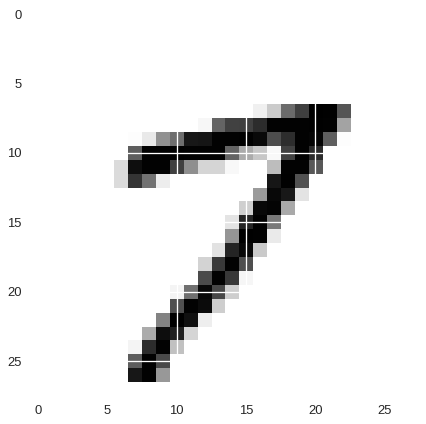

In [14]:
plot_mnist_image(1523,imgs_orig,label_orig)

In [0]:
imgs_train_orig,label_train_orig=train_orig_data
imgs_test_orig,label_test_orig=test_orig_data

In [16]:
label_train_orig.shape

(60000,)

We will design a network that will be able to recognize that the image is showing the number 7 (for all the images in the test set)

## Data transform

We need to change the shape of the data, so it can be fed to the network more easily

In [17]:
#tenemos que meter la imagen(matriz), tenemos que transformarla en un vector. Podemos hacerlo a mano, poniendo cada una de las columnas de la matriz una debajo de la otra para formar un vector.
j=imgs_train_orig[523]
j.shape

(28, 28)

In [18]:
#transformamos a matriz usando reshape(), transforma cogiendo las cosas por columnas
t=j.reshape((28*28,))
t.shape

(784,)

All the images are 28x28 matrices, with values between 0 and 255. Let's normalize the images, to avoid problems in the numerical computations using large numbers.

We will convert the matrix to a vector with 28x28 components, stacking columns on top of each other. This will make the design of the network.
* Alternatively, we could add a `Flatten(input_shape=(28,28))` layer to the model

In [0]:
imgs_train_t=imgs_train_orig.reshape((60000,28*28))
#ahora lo hacemos con todo, estamos transformando un tensor en una matriz.
#aplicamos lo mismo para el test:
imgs_test_t=imgs_test_orig.reshape((10000,28*28))

In [21]:
imgs_train_t.shape

(60000, 784)

In [22]:
imgs_test_t.shape

(10000, 784)

In [23]:
imgs_train_t[523].max()

255

In [0]:
#ahora vamos a normalizar, en este caso dividiendo entre 255, para obtener datos entre 0 y 1, esto nos ayudará en el proceso de ajuste.
#en DL no hay que hacer feature ingeniering, aunque aqui estamos haciendo esto pero es que esto lo pueden hacer capas por nosotros por eso la primera afirmacion.
imgs_train_t=imgs_train_orig.reshape((60000,28*28))/255
imgs_test_t=imgs_test_orig.reshape((10000,28*28))/255

In [25]:
imgs_train_t[523].max()

1.0

Because we want to assign a *category* to each image, we need to transform the output to categorical format

In [26]:
label_train_orig[0:10]
#esto no es un problema de regresion, no queremos precedir numeros, queremos predecir categorias, que en este caso son categorias. Hay que transformar los datos en categorico-> haciendo 1-HOT enconding format

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

Initially, our target data is just a set of numbers

We are going to transform it to **1-HOT encoding format**

In [0]:
#transformar un numero en un vector de 1-HOT encoding, keras nos ayuda a hacer esto. Esto se hace pq la red comparará vectores.
from keras.utils import to_categorical

In [0]:
label_train_t=to_categorical(label_train_orig)
label_test_t=to_categorical(label_test_orig)

In [29]:
label_train_orig[5]

2

In [30]:
label_train_t[5]#tiene un 1 en la segunda posicion del vector

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [31]:
label_train_orig[1523]

7

In [32]:
label_train_t[1523]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

We have to repeat the same process with the test data

## Let's build the model

In [0]:
from keras import models, layers
m=models.Sequential()

In [0]:
m.add(layers.Dense(128, input_shape=(28*28,), activation='relu'))
#añadimos otra capa
m.add(layers.Dense(64, activation='relu'))
#capa por defecto de salida, que tendrá dimension 10 ya que se han transformado en 1-HOT vectors. La capa de salida tiene que tener una funcion de activacion concreta en este caso ya que queremos que nos devuelva la probabilidad, si no lo hiceramos nos devolveria un numero
m.add(layers.Dense(10, activation='softmax'))

In [0]:
from keras import optimizers, losses, metrics

In [0]:
#compilamos
m.compile(
  optimizer=optimizers.rmsprop(),
  loss=losses.categorical_crossentropy,#usamos una funcion de perdidas de tipo categorica
  metrics=[metrics.categorical_accuracy]#añado una metrica interpretable desde un punto de vista humano: el accuracy. Pero el accuracy en un problema de calsificacion es malo (por ejemplo en casificadores binarios), podriamos usar la matriz de confusión, curva roc que permite comparar dos clasificadores de una forma mas genérica.
)

In [41]:
h=m.fit(imgs_train_t,label_train_t,epochs=80,batch_size=1024,validation_split=.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/80
48000/48000 [==============================] - 1s 18us/step - loss: 0.7536 - categorical_accuracy: 0.7985 - val_loss: 0.3514 - val_categorical_accuracy: 0.9019
Epoch 2/80
48000/48000 [==============================] - 1s 11us/step - loss: 0.3155 - categorical_accuracy: 0.9106 - val_loss: 0.2720 - val_categorical_accuracy: 0.9180
Epoch 3/80
48000/48000 [==============================] - 1s 10us/step - loss: 0.2415 - categorical_accuracy: 0.9304 - val_loss: 0.2053 - val_categorical_accuracy: 0.9435
Epoch 4/80
48000/48000 [==============================] - 1s 11us/step - loss: 0.1982 - categorical_accuracy: 0.9417 - val_loss: 0.1885 - val_categorical_accuracy: 0.9452
Epoch 5/80
48000/48000 [==============================] - 0s 10us/step - loss: 0.1692 - categorical_accuracy: 0.9506 - val_loss: 0.1710 - val_categorical_accuracy: 0.9486
Epoch 6/80
48000/48000 [==============================] - 0s 10us/step - loss: 0.1450 - categor

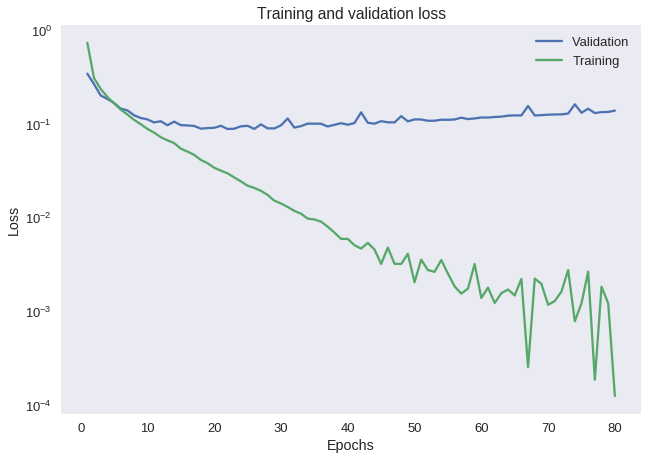

In [42]:
plot_metric(h,'loss')
#vamos que hay overfitting --> el error de validacion va subiendo....
#ponemos 30 epocas y ejecutamos desde el principio

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 1s 15us/step - loss: 0.7514 - categorical_accuracy: 0.7980 - val_loss: 0.3322 - val_categorical_accuracy: 0.9079
Epoch 2/30
48000/48000 [==============================] - 1s 11us/step - loss: 0.3139 - categorical_accuracy: 0.9101 - val_loss: 0.2568 - val_categorical_accuracy: 0.9271
Epoch 3/30
48000/48000 [==============================] - 1s 11us/step - loss: 0.2403 - categorical_accuracy: 0.9312 - val_loss: 0.2118 - val_categorical_accuracy: 0.9389
Epoch 4/30
48000/48000 [==============================] - 0s 10us/step - loss: 0.1994 - categorical_accuracy: 0.9425 - val_loss: 0.1753 - val_categorical_accuracy: 0.9497
Epoch 5/30
48000/48000 [==============================] - 0s 10us/step - loss: 0.1711 - categorical_accuracy: 0.9506 - val_loss: 0.1574 - val_categorical_accuracy: 0.9551
Epoch 6/30
48000/48000 [==============================] - 0s 10us/step - loss: 0.1493 - categor

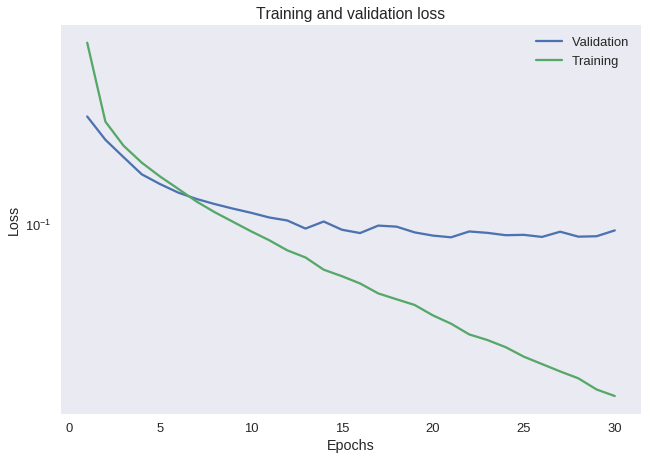

In [43]:
m=models.Sequential()
m.add(layers.Dense(128, input_shape=(28*28,), activation='relu'))
#añadimos otra capa
m.add(layers.Dense(64, activation='relu'))
#capa por defecto de salida, que tendrá dimension 10 ya que se han transformado en 1-HOT vectors. La capa de salida tiene que tener una funcion de activacion concreta en este caso ya que queremos que nos devuelva la probabilidad, si no lo hiceramos nos devolveria un numero
m.add(layers.Dense(10, activation='softmax'))
m.compile(
  optimizer=optimizers.rmsprop(),
  loss=losses.categorical_crossentropy,#usamos una funcion de perdidas de tipo categorica
  metrics=[metrics.categorical_accuracy]#añado una metrica interpretable desde un punto de vista humano: el accuracy. Pero el accuracy en un problema de calsificacion es malo (por ejemplo en casificadores binarios), podriamos usar la matriz de confusión, curva roc que permite comparar dos clasificadores de una forma mas genérica.
)
h=m.fit(imgs_train_t,label_train_t,epochs=30,batch_size=1024,validation_split=.2)
plot_metric(h,'loss')

In [0]:
#ahora vemos que baja, y es mejor.

In [44]:
#vemos el accuracy
plot_metric(h,'accuracy')

KeyError: ignored

In [45]:
#usamos el test
m.evaluate(imgs_test_t,label_test_t)

10000/10000 [==============================] - 1s 61us/step


[0.07937326894756698, 0.9783]

In [0]:
#el valor de la funcion de perdidas es del 0.079 y el accuracy en el conjunto de test es 0.97 sobre 1, un 97% que está muy bien.
#TENEMOS QUE PREGUNTARNOS, ES BUENO EL MODELO? HAY QUE EVALUARLO CON MAS DETALLE

Here we will make some decisions about how to train our model.

The **objective function**, called **loss function** in Deep Learning, will be *categorical crossentropy*. This is because we are trying to predict discrete classes. If we choose a different function, the solution will be different. This is the function that will tell us when we have found the *solution*. Different functions will point to different *solutions*.

The **optimizer** is the method that we will use to find the minimum of the **loss function**. In general, we will not find the global minimum of the loss function, but a minimum that is good enough. *RMSProp* is one the variants of gradient descent. But there are many more:
 - http://ruder.io/optimizing-gradient-descent/
 
These two settings will define what solution we will find during the training process.

The other parameter, the **metrics**, is only for information purposes. In each step of the training (called **epoch**), Keras will report the value of the metrics. But whether we choose one metric or another will not influence the training process. It is only for reporting how the training is going. That information will be useful for the validation of the model, that is, for the **hyperparameters tuning**.


Now let's fit the neural network. We will keep the results in a *history* object to plot some parameters after the training, and use that information for improving our model (changing layers, activation functions, etc). This process is called **hyperparameters tuning** or hypeparameters search.

Here we need to set two parameters: the number of **epochs** and the **batch size**.

In previous cells, I have said that the training process is an optimization problem: we try to find the minimum.

That's actually not entirely true. In practice, we don't keep searching for a minimum. Instead, we train for a preset number of epochs. Then we analyze the output using the validation set. If we detect overfit, then we reduce the number of epochs. If we don't detect it, then maybe we can keep going for some more epochs to find a better model. The number of epochs is another hyperparameter. In general, we should stop the training as early as possible. Any further epoch can make our model overfit, and therefore generalize poorly.

The batch size is another hyperparameter. The network is not updated item by item, vector by vector. We can actually calculate the weights for a batch of several items, forming a matrix or a tensor. The batch size will affect the granularity of the calculations and the performance. A larger batch size will probably result in a slightly worse accuracy, but in a better performance. As long as the batch size is not so huge that it cannot be kept in memory. Because we are running on a GPU, it is a good idea to use a power of 2 for the batch size. It will probably make a better use of the GPU. But again, the effect of the batch size must be tested using the validation set, and adjusted until we find a good value for that parameter.

An epoch is a full pass over the training dataset. At the end of each epoch, Keras will calculate the value of the metrics for the training set, and the loss function and metrics for the validation set. The loss and metrics of the validation set are useful for the hyperparameters tuning process.



In [0]:
#PROBAR CON OTRAS FUNCIONES DE ACTIVACION QUE NO SEAN LA RELU

## Exercises

* **EXERCISE 1**: Chante the activation function in the model. How does it affect accuracy? What happens if you use linear activation function? What happens if we use the $\tanh$ function? Does it affect to overfitting?
 * https://keras.io/activations/
 
Here we see that the accuracy keeps increasing over epochs. An overfitted model would produce a decrease of the validation accuracy at some point. This means that we have found an optimal model. The validation loss is stuck at a minimum, but the accuracy is not affected by the extra epochs.

_**EXERCISE 2**_: How is the model accuracy (measured with the test set, see below) affected if we start over and fit for 40 epochs? And for 4? And for 400?

_**EXERCISE 4**_: What is the most simple model that you can get that achieves a similar validation performance (accuracy)? (the loss values are not comparable, different networks will have different ranges of values for the loss functions)

Now let's check how well the model works with the test dataset. Remember that we don't have used it at all during the training and tuning of the model.

In [0]:
#HACER EJERCICIOS...

## Analyze the classification performance

In [48]:
_,acc=m.evaluate(imgs_test_t,label_test_t)

10000/10000 [==============================] - 1s 61us/step


In [49]:
#¿cuantas imagenes mal clasificadas en el conjunto de test?
acc*imgs_test_t.shape[0] #son las imágenes que he acertado

9783.0

In [50]:
(1-acc)*imgs_test_t.shape[0] #se ha equivocado en 217 imágenes que está muy bien, pero pq a pasado esto? tenemos que investigar mas.

217.0000000000005

That's about a $98\%$ accuracy on the test set. Not bad.

With that accuracy, this is the number of images that are wrongly classified by our model:

Let's see how well it predicts some random items from the test set.

The image below should show the number 8


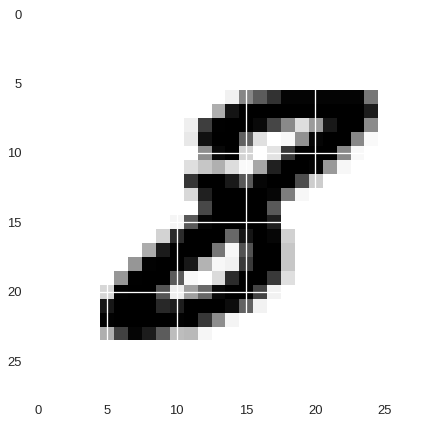

In [51]:
plot_mnist_image(2543, imgs_test_orig, label_test_orig)#con esta imagen vamos a evaluar la precision de este modelo

The prediction is a 10-element vector (*1-HOT encoded vector*), with the probability of each class. The location of the max is giving us the predicted class.

In [52]:
#para predecir tenemos que usar los datos transformados (imgs_test_t)
m.predict(imgs_test_t[2543:2544])

array([[8.8292772e-06, 3.1183905e-04, 1.8901487e-07, 1.3243302e-06,
        1.5275361e-11, 7.5737612e-06, 3.9917063e-07, 2.8440812e-07,
        9.9966955e-01, 1.4925202e-08]], dtype=float32)

In [53]:
#Pero necesitamos saber cual es el valor, es decir donde está el maximo, lo hacemos con numpy
np.argmax(m.predict(imgs_test_t[2543:2544]))

8

YES! Our model predicts 8

_**EXERCISE 5**_: Can you find a test item that is predicted wrongly? How many images are predicted wrongly? Can you find all the items that are wrongly classified? For instance, the test element with index 3943 is a 3 but we predict a 5


In [57]:
#¿Podemos encontrar algo que esté mal clasificado?
#calculamos las predicciones, les voy a pasar al modelo el tensor entero
preds=m.predict(imgs_test_t)
preds.shape

(10000, 10)

In [58]:
#tengo que volver a aplircar el argmax pero indicando el eje en el que quiero que se aplique, quiero quedarme en que columna aparece el maximo en cada fila
preds=np.argmax(m.predict(imgs_test_t),axis=1)
preds.shape

(10000,)

In [63]:
#comparacion para ver donde falla
pos=np.where(preds==label_test_orig)
pos[0].shape

(9783,)

In [65]:
#Para ver que no ha acertado
pos=np.where(preds!=label_test_orig)[0]
pos.shape

(217,)

In [66]:
pos[56]

1984

The image below should show the number 2


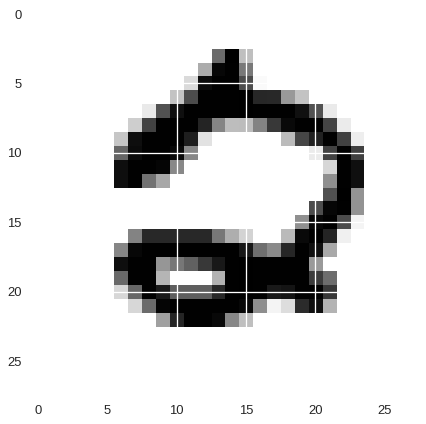

In [68]:
plot_mnist_image(1984, imgs_test_orig, label_test_orig)

In [72]:
np.argmax(m.predict(imgs_test_t[1984:1985,]))

0

In [75]:
#aplicando esto en las posiciones que están mal
wrong_preds=preds[pos]
wrong_preds[0:15]
#posiciones donde el modelo ha dicho nu numero diferente.
#Vmos a analizar los numeros a ver como se comportan

array([6, 2, 7, 3, 4, 6, 2, 2, 8, 8, 1, 3, 4, 8, 7])

Ok, but in which positions can we find all the misclassifications?

In [0]:
import pandas as pd

In [79]:
s=pd.Series(np.bincount(wrong_preds)).to_frame()#transformamos en DF
#Quiero contar cuantas veces aparece cada numero en la serie

s.head()

,0
0,18
1,26
2,25
3,38
4,20


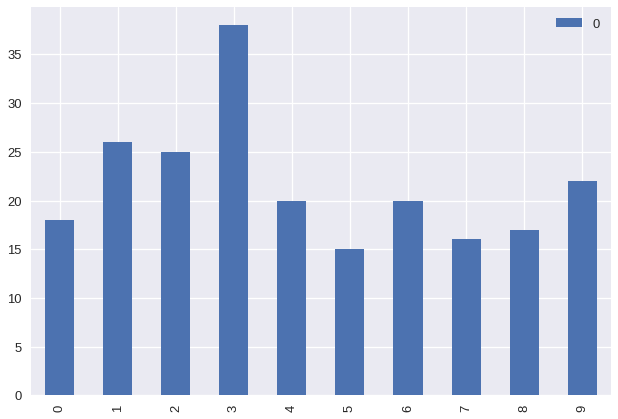

In [80]:
s.plot.bar()

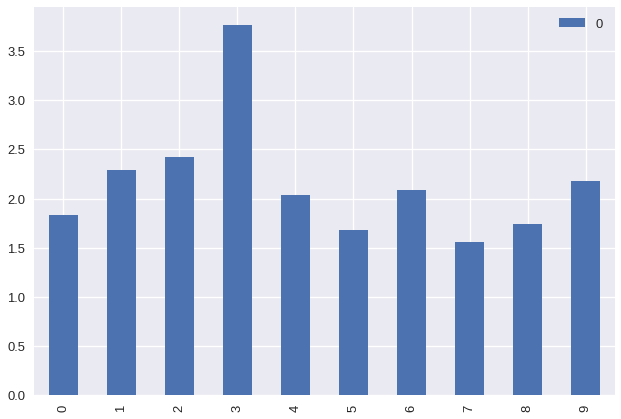

In [82]:
#el balanceo de los datos es fundamental para que salga bien. 
w=pd.Series(np.bincount(wrong_preds))
a=pd.Series(np.bincount(label_test_orig))#todas las etiquetas del conjunto de datos de test

p=w/a*100

p.to_frame().plot.bar()

In [0]:
#Vemos que tiene problemas con el reconocimiento de los 3

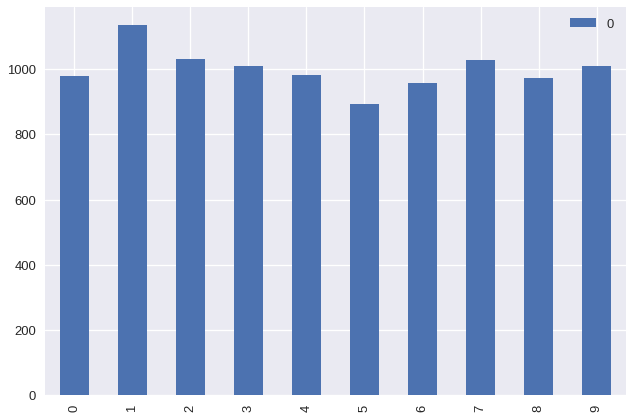

In [83]:
#REVISAR TODO ESTA CELDA. comprobacion de si los datos están balanceados. El nº de veces que los datos aparecen en train o en test. EN este caso estan bastante, algo que no suele ser normal. Esto es un ejemplo preparado
a.to_frame().plot.bar()

_**EXERCISE 6**_: Some digits are more difficult to recognize than others. Because we know the test labels, we can find out how many times the corresponding test images are misclassified. Could you find what are the top 3 test labels that are more often misclassified?

Let's check some wrong predictions

The image below should show the number 9


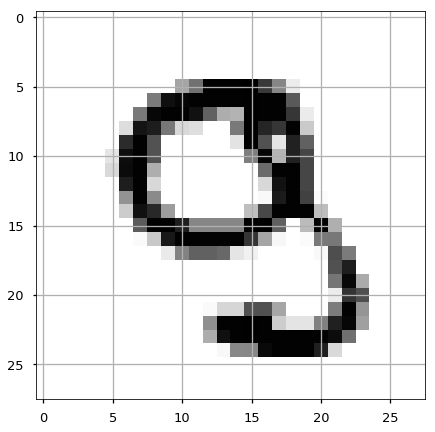

In [0]:
plot_mnist_image(151, test_imgs, test_labels)

In [0]:
preds_labels[151]

8

These are the items that are wrongly classified:

So we see that $9$ is wrongly classified more than the rest. But does it mean that our model has more difficulties recognizing 9s?

Our model has the most difficulties recognizing 9s, 5s and 4s

# comprobacion flatten y otras capas para minimizar el tratamiento de los datos

In [0]:
m=models.Sequential()

In [0]:
m.add(layers.Dense(128, input_shape=(28*28,), activation='relu'))
m.add(layers.Dense(64, activation='relu'))
m.add(layers.Dense(10, activation='softmax'))

In [0]:
m.compile(
  optimizer=optimizers.rmsprop(),
  loss=losses.categorical_crossentropy,#usamos una funcion de perdidas de tipo categorica
  metrics=[metrics.categorical_accuracy]#añado una metrica interpretable desde un punto de vista humano: el accuracy. Pero el accuracy en un problema de calsificacion es malo (por ejemplo en casificadores binarios), podriamos usar la matriz de confusión, curva roc que permite comparar dos clasificadores de una forma mas genérica.
)

In [0]:
h=m.fit(imgs_train_t,label_train_t,epochs=30,batch_size=1024,validation_split=.2)
m.summary()
# en este caso el modelo nunca va a encajar, pq hay que transdormar los datos antes. En este caso, no lo vamos a hacer manualmente, lo hará keras.
#siempre que usemos capas densas y queramos meter matrices (imagenes), tenemos que usar una capa Flatten. Las capas flatten conectará zonas convolucional de la red
#con la zona densa será la de entrenamiento que recibirá como entrada vectores.

In [93]:
m=models.Sequential()

m.add(layers.Flatten(input_shape=(28,28)))#en el input shape parece que está el error.
m.add(layers.BatchNormalization())#esta capa normaliza, viene muy bien con redes grandes
m.add(layers.Dense(128, activation='relu'))
m.add(layers.Dense(64, activation='relu'))
m.add(layers.Dense(10, activation='softmax'))

m.compile(
  optimizer=optimizers.rmsprop(),
  loss=losses.categorical_crossentropy,#usamos una funcion de perdidas de tipo categorica
  metrics=[metrics.categorical_accuracy]#añado una metrica interpretable desde un punto de vista humano: el accuracy. Pero el accuracy en un problema de calsificacion es malo (por ejemplo en casificadores binarios), podriamos usar la matriz de confusión, curva roc que permite comparar dos clasificadores de una forma mas genérica.
)

h=m.fit(imgs_train_orig,label_train_orig,epochs=30,batch_size=1024,validation_split=.2)

m.evaluate(imgs_test_orig,label_test_orig)

ValueError: ignored

1. capas->input shape
2. activation (RELU)
3. Optimizador, losses.
4. Epoch, batch_size

Train(parametros)
validation(hiperparametros)
test(nunca en el fit)